<a href="https://colab.research.google.com/github/Kusuru-Meghana/childhood-obesity-prediction/blob/main/notebooks/predicting_childhood_obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting Childhood Obesity using 2020 NSCH Data


## Project Overview
The goal of this project is to use data from the **2020 National Survey of Children's Health (NSCH)** to predict whether children aged 10–17 are **overweight or obese** based on their lifestyle, demographic, and family characteristics.

## Why This Matters
Childhood obesity is a major public health concern linked to long-term health problems like diabetes, heart disease, and mental health issues. Understanding which factors are most associated with higher BMI can help inform prevention strategies.

## Dataset Information
- **Source:** U.S. Census Bureau & HRSA Maternal and Child Health Bureau  
- **Year:** 2020  
- **Total respondents:** ~42,777 children nationwide  
- **Target group for this project:** Children aged **10–17 years**  
- **Target variable:** BMICLASS (BMI category based on parent-reported height/weight)  
  - 1 = Underweight (<5th percentile)  
  - 2 = Normal (5th–84th percentile)  
  - 3 = Overweight (85th–94th percentile)  
  - 4 = Obese (≥95th percentile)  

We will simplify this into a **binary classification problem**:  
- `0` = Underweight or Normal  
- `1` = Overweight or Obese  

This approach makes the model easier to interpret and helps deal with class imbalance.


## Step 1: Load the Dataset
Starting by loading the 2020 NSCH Public Use File (CSV format) into Python.  
I am using `pandas` library for data handling.  


In [ ]:
# Step 1: Loading the dataset
import pandas as pd

# Loading the CSV file
df = pd.read_csv("/content/2020 NSCH_Topical _CAHMI_DRC_v2.csv")

# Checking the number of rows and columns & first few lines
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (42777, 831)


,FIPSST,STRATUM,HHID,FORMTYPE,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,...,nom25ForgoneHC_20,BREASTFEDEND_MO_S,FRSTFORMULA_MO_S,FRSTSOLIDS_MO_S,BREASTFEDEND_DAY_S,BREASTFEDEND_WK_S,FRSTFORMULA_DAY_S,FRSTFORMULA_WK_S,FRSTSOLIDS_DAY_S,FRSTSOLIDS_WK_S
0,17,1,20000003,1,2,1,1,3,1,95,...,2,15,95,6,98,98,95,95,98,98
1,29,2,20000004,3,1,1,1,14,2,95,...,2,90,90,90,90,90,90,90,90,90
2,47,1,20000005,1,1,1,1,1,2,95,...,2,14,8,12,98,98,98,98,98,98
3,28,1,20000014,3,2,1,1,15,2,95,...,2,90,90,90,90,90,90,90,90,90
4,55,1,20000015,3,2,2,1,16,2,95,...,2,90,90,90,90,90,90,90,90,90


## Step 2: Filter Data and Create the Target Variable

The `BMICLASS` variable in the NSCH dataset categorizes children’s BMI into:
1. Underweight (<5th percentile)
2. Normal (5th–84th percentile)
3. Overweight (85th–94th percentile)
4. Obese (≥95th percentile)

However, BMI is only calculated for **children aged 10–17 years**.

In this step, I will:
1. Keep only rows where `SC_AGE_YEARS` is between 10 and 17.
2. Remove rows where `BMICLASS` is missing or coded with special values like 90, 95, or 99 (these mean “Not Applicable” or “Missing” in NSCH).
3. Create a new binary target variable called `ObeseBinary`:
   - `0` → Underweight (1) or Normal (2)
   - `1` → Overweight (3) or Obese (4)


In [ ]:
# Step 2: Filtering data for ages 10-17 and creating binary obesity variable

# I only want kids aged 10 to 17, so we filter out everyone else. Why? only for that age we have BMI values
df_filtered = df[df['SC_AGE_YEARS'].between(10, 17)]

# Removing the rows with invalid or missing BMICLASS values
valid_bmi_values = [1, 2, 3, 4]  # got from the codebook
df_filtered = df_filtered[df_filtered['BMI4_20'].isin(valid_bmi_values)]

# Creating binary target variable -  Making the "Obese or Not" Column
# 1 = Overweight or Obese
# 0 = Underweight or Normal
df_filtered['ObeseBinary'] = df_filtered['BMI4_20'].apply(lambda x: 1 if x in [3, 4] else 0)

# Checking the result
print("Rows after filtering:", df_filtered.shape[0])
print("\nDistribution of binary obesity variable:")
print(df_filtered['ObeseBinary'].value_counts())


Rows after filtering: 21511

Distribution of binary obesity variable:
ObeseBinary
0    15299
1     6212
Name: count, dtype: int64


## Step 3: Select & Clean Features

Now I am selecting few features that research shows are related to childhood obesity, based on the NSCH 2020 codebook.

| Column Name   | Description | Why It's Important |
|---------------|-------------|--------------------|
| SC_AGE_YEARS  | Child's age in years | BMI naturally changes with age, so this is a key control variable. |
| SC_SEX        | Child's sex | There may be differences in obesity rates by sex. |
| PHYSACTIV     | Number of days in the past week with ≥60 minutes of physical activity | Less activity is often linked with higher BMI. |
| SCREENTIME    | Average daily screen time | High screen time can correlate with lower physical activity and higher BMI. |
| SLEEP         | Average hours of sleep per night | Poor sleep is associated with obesity risk. |
| FPL_I1        | Household income-to-poverty ratio | Socioeconomic status can affect diet and activity levels. |
| HHLANGUAGE    | Primary language spoken at home | A proxy for cultural/linguistic background, which may influence lifestyle. |

Next -
1. Keep only these columns and the target variable.
2. Remove rows where any of these features have "special missing" codes like 90, 95, or 99.


In [ ]:
# Updated feature selection using actual CSV column names
# Picking the columns we think matter most for predicting obesity
selected_cols = [
    'SC_AGE_YEARS',  # age
    'SC_SEX',        # sex
    'PHYSACTIV',     # physical activity days/week
    'SCREENTIME',    # screen time
    'HOURSLEEP',     # hours of sleep/night
    'FPL_I1',        # income-to-poverty ratio
    'HHLANGUAGE',    # primary household language
    'ObeseBinary'    # target
]

df_model = df_filtered[selected_cols].copy()

# Defining special missing codes from NSCH documentation
special_missing = [90, 95, 99]

# Remove the rows where important features have missing code
df_model = df_model[~df_model.drop(columns=['ObeseBinary']).isin(special_missing).any(axis=1)]

# Checking the cleaned dataset
print("Rows after cleaning:", df_model.shape[0])
df_model.head()


Rows after cleaning: 20948


,SC_AGE_YEARS,SC_SEX,PHYSACTIV,SCREENTIME,HOURSLEEP,FPL_I1,HHLANGUAGE,ObeseBinary
1,14,2,2,5,4,400,1,0
3,15,2,2,5,4,143,1,0
4,16,2,1,4,4,400,1,1
8,14,2,2,4,3,50,1,1
12,17,1,2,3,3,50,1,0


## Step 4: Exploratory Data Analysis (EDA)

Before I train a machine learning model, I am exploring the dataset visually.

So,
1. Look at the balance of target variable (`ObeseBinary`).
2. Plot histograms for numerical features like age, physical activity, screen time, and sleep.
3. Look at obesity rates by categories like sex and household language.


/tmp/ipython-input-3453762114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ObeseBinary', data=df_model, palette='Set2')


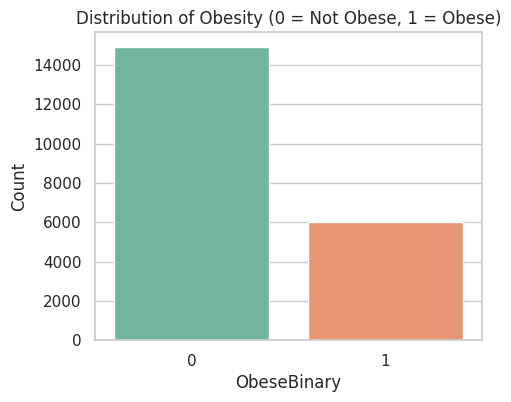

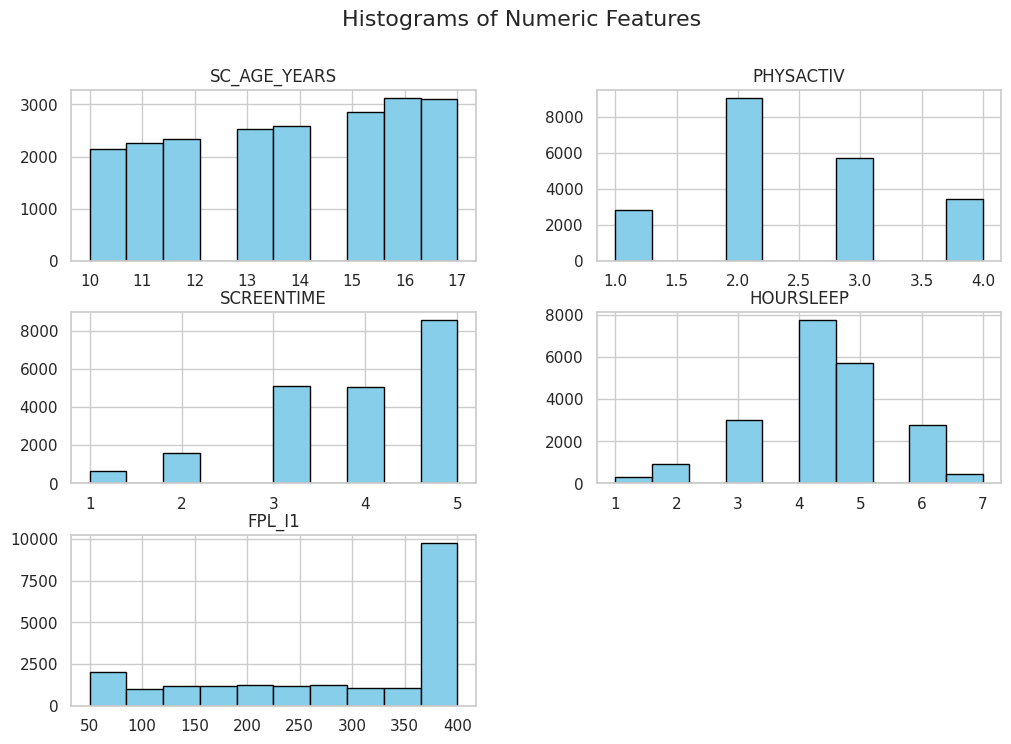

/tmp/ipython-input-3453762114.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='SC_SEX', y='ObeseBinary', data=df_model, ci=None, palette='Set1')
/tmp/ipython-input-3453762114.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SC_SEX', y='ObeseBinary', data=df_model, ci=None, palette='Set1')


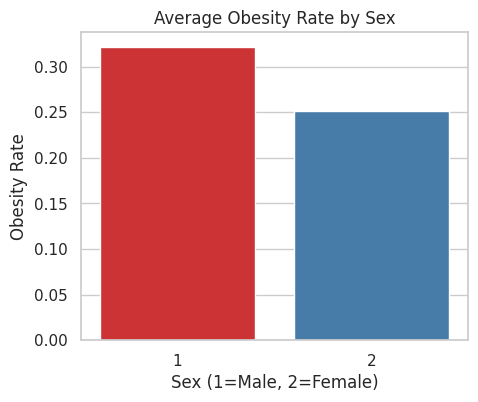

/tmp/ipython-input-3453762114.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='HHLANGUAGE', y='ObeseBinary', data=df_model, ci=None, palette='Set3')
/tmp/ipython-input-3453762114.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HHLANGUAGE', y='ObeseBinary', data=df_model, ci=None, palette='Set3')


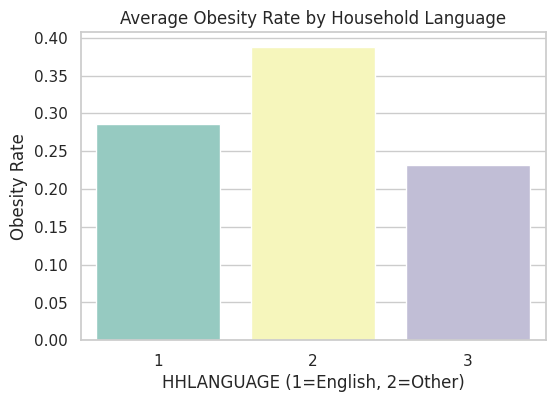

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid")

# 1. Target variable distribution
plt.figure(figsize=(5,4))
sns.countplot(x='ObeseBinary', data=df_model, palette='Set2')
plt.title("Distribution of Obesity (0 = Not Obese, 1 = Obese)")
plt.xlabel("ObeseBinary")
plt.ylabel("Count")
plt.show()

# 2. Histograms for numeric features
numeric_features = ['SC_AGE_YEARS', 'PHYSACTIV', 'SCREENTIME', 'HOURSLEEP', 'FPL_I1']

df_model[numeric_features].hist(bins=10, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()

# 3. Obesity rate by sex
plt.figure(figsize=(5,4))
sns.barplot(x='SC_SEX', y='ObeseBinary', data=df_model, ci=None, palette='Set1')
plt.title("Average Obesity Rate by Sex")
plt.xlabel("Sex (1=Male, 2=Female)")
plt.ylabel("Obesity Rate")
plt.show()

# 4. Obesity rate by primary household language
plt.figure(figsize=(6,4))
sns.barplot(x='HHLANGUAGE', y='ObeseBinary', data=df_model, ci=None, palette='Set3')
plt.title("Average Obesity Rate by Household Language")
plt.xlabel("HHLANGUAGE (1=English, 2=Other)")
plt.ylabel("Obesity Rate")
plt.show()


## Step 5: Encode Categorical Features and Split Data

Machine learning algorithms work best with numerical inputs.

So I will:
1. Encode categorical variables into numbers using `LabelEncoder`.
   - `SC_SEX`: 1 = Male, 2 = Female
   - `HHLANGUAGE`: 1 = English, 2 = Other language, 3 = Missing/Other
2. Split our dataset into:
   - Training set (80%): Used to train the model.
   - Testing set (20%): Used to evaluate how well the model works on unseen data.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 5.1: Encode categorical features
df_encoded = df_model.copy()
categorical_cols = ['SC_SEX', 'HHLANGUAGE']

#Machine learning works with numbers, not words, so turning      "Male/Female" and "English/Other" into 0s and 1s.
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Step 5.2: Define features (X) and target (y)
X = df_encoded.drop(columns=['ObeseBinary'])
y = df_encoded['ObeseBinary']

# Step 5.3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing
    random_state=42,      # reproducibility
    stratify=y            # keep class proportions same in train/test
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 16758
Testing set size: 4190


## Step 6: Train a Machine Learning Model & Evaluate

1. Train a **Random Forest Classifier** to predict obesity (`ObeseBinary`).
2. Make predictions on the test set.
3. Evaluate model performance using:
   - Accuracy
   - Confusion Matrix
   - Precision, Recall, and F1-Score


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      2984
           1       0.33      0.28      0.31      1206

    accuracy                           0.63      4190
   macro avg       0.53      0.53      0.53      4190
weighted avg       0.61      0.63      0.62      4190


Confusion Matrix:
 [[2300  684]
 [ 864  342]]


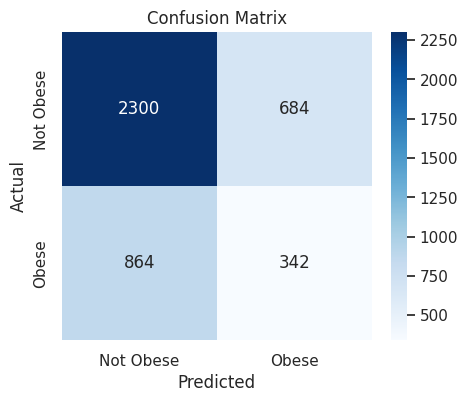

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 6.1: Train Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Step 6.2: Making predictions
y_pred = rf.predict(X_test)

# Step 6.3: Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 6.4: Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Step 7: Fix Class Imbalance using SMOTE

Our dataset has more "Not Obese" cases than "Obese" cases.
This imbalance makes the model biased toward predicting "Not Obese".

We will:
1. Using SMOTE to oversample the minority class (Obese).
      *SMOTE creates synthetic samples of the minority class (Obese) to balance the dataset
      *SMOTE makes new synthetic obese samples based on existing ones.
      *We only apply SMOTE to the training data — never to the test set.

2. Training the model again on the balanced dataset.
3. Comparing results with the previous model.


Before SMOTE: {0: 11936, 1: 4822}
After SMOTE: {0: 11936, 1: 11936}
Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.74      0.68      0.71      2984
           1       0.34      0.41      0.37      1206

    accuracy                           0.60      4190
   macro avg       0.54      0.54      0.54      4190
weighted avg       0.62      0.60      0.61      4190


Confusion Matrix:
 [[2023  961]
 [ 712  494]]


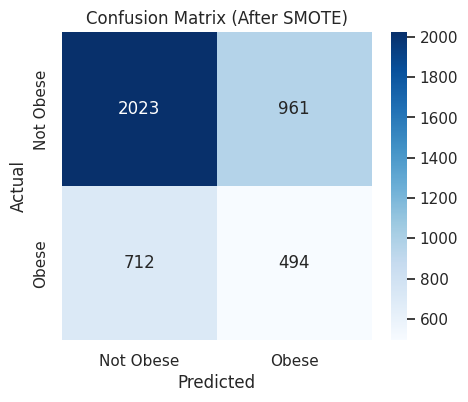

In [ ]:
from imblearn.over_sampling import SMOTE

# Step 7.1: Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_resampled.value_counts().to_dict())

# Step 7.2: Train Random Forest again
rf_balanced = RandomForestClassifier(n_estimators=200, random_state=42)
rf_balanced.fit(X_train_resampled, y_train_resampled)

# Step 7.3: Evaluate new model
y_pred_balanced = rf_balanced.predict(X_test)

print("Classification Report (Balanced Data):\n", classification_report(y_test, y_pred_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

# Step 7.4: Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (After SMOTE)')
plt.show()


## Step 8: Feature Importance

Now that model has been trained on balanced data using SMOTE, let's see which features it found most important when predicting obesity.

1. Extract the feature importance values from Random Forest model.
2. Display them in a table (feature name + importance score).
3. Plot them in a horizontal bar chart for easier visual understanding.


Feature Importance Table:
        Feature  Importance
5        FPL_I1    0.483707
0  SC_AGE_YEARS    0.146728
4     HOURSLEEP    0.113226
3    SCREENTIME    0.096461
2     PHYSACTIV    0.088589
1        SC_SEX    0.045909
6    HHLANGUAGE    0.025381


/tmp/ipython-input-1792553631.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


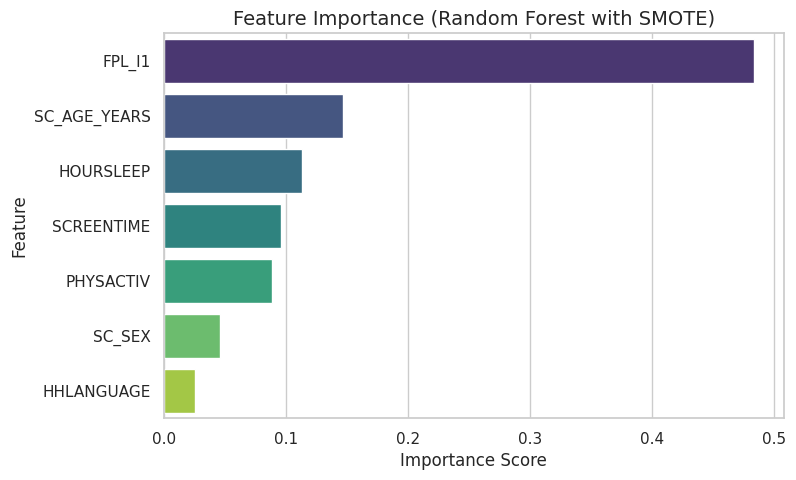

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 8.1: Get feature importance scores
feature_importances = rf_balanced.feature_importances_
features = X.columns

# Step 8.2: Create a DataFrame for easier viewing
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 8.3: Show as table
print("Feature Importance Table:")
print(fi_df)

# Step 8.4: Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Feature Importance (Random Forest with SMOTE)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
